# Introducción a las Redes Neuronales YOLO

YOLO, acrónimo de "You Only Look Once" (Solo Miras Una Vez), es una familia de modelos de redes neuronales convolucionales diseñados para tareas de detección de objetos en tiempo real. A diferencia de otros métodos que aplican modelos de clasificación sobre múltiples regiones de una imagen, YOLO realiza la detección de objetos en una sola pasada a través de la red neuronal, lo que lo hace extremadamente rápido y eficiente.

### ¿Para qué se usa YOLO?

YOLO se utiliza principalmente en aplicaciones donde la velocidad es crítica, como en vehículos autónomos, vigilancia, robótica y realidad aumentada. Su capacidad para procesar imágenes en tiempo real permite identificar y localizar múltiples objetos en una escena de manera rápida y precisa.

### Cómo Funciona YOLO

YOLO divide la imagen de entrada en una cuadrícula de $S \times S$ celdas. Cada celda es responsable de predecir un número fijo de cajas delimitadoras (bounding boxes) y las probabilidades de clase para esos cuadros si contienen el centroide de un objeto.

Cada caja delimitadora predice:

- **Coordenadas**: $x, y$ (posición relativa al cuadrante), $w, h$ (ancho y alto relativos a la imagen completa).
- **Confianza**: una puntuación que indica la probabilidad de que la caja realmente contenga un objeto y qué tan precisa es la caja.


Para cada caja, se predicen las probabilidades de clase condicionadas a que exista un objeto en esa caja.

Después de obtener todas las predicciones, se aplica la supresión de no máximos para eliminar las cajas redundantes y mantener solo las más probables.

Para esta sección, utilizaremos la librería `ultralytics`, que proporciona una implementación sencilla de YOLOv5 y YOLOv8 en PyTorch.




## Importación de Librerías y selección de dispositivo



In [1]:
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from skimage import io, data
import numpy as np

# Selección de device (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando device: {device}")


Usando device: cuda



## Carga del Modelo Pre-entrenado



In [ ]:
# Cargar el modelo YOLOv5 pre-entrenado y moverlo al device seleccionado
model = YOLO('yolov5s.pt')  # Puedes cambiar a 'yolov8s.pt' para YOLOv8

PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_st


## Visualización y Explicación de la Arquitectura del Modelo

Podemos imprimir el modelo para entender su estructura.



In [ ]:
# Imprimir la arquitectura del modelo
model.to(device)
print(model.model)


DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
     


### Explicación de la Estructura General de una YOLO

El modelo YOLOv5 consta de tres partes principales:

1. **Backbone**: Una red convolucional (por ejemplo, CSPDarknet) que extrae características de la imagen de entrada.
2. **Neck**: Un agregador de características (como FPN o PANet) que combina características de diferentes niveles de profundidad.
3. **Head**: La parte final que predice las cajas delimitadoras, las clases y las puntuaciones de confianza. Las bounding boxes se forman a partir de las salidas del modelo, que incluyen predicciones de coordenadas, dimensiones, confianza y clases para múltiples anclas en diferentes escalas.

La functionalidad de una YOLOv5 consta de lo siguiente:

- **Focus Layer**: Reduce el tamaño de la imagen y aumenta las características.
- **CSP (Cross Stage Partial Networks)**: Permite que el flujo de datos se divida y combine, mejorando la eficiencia y reduciendo la redundancia.
- **SPP (Spatial Pyramid Pooling)**: Captura información en múltiples escalas.

### Función de Pérdida

La función de pérdida en YOLO combina varios componentes:

- **Pérdida de ubicación (Localization Loss)**: Mide la diferencia entre las cajas predichas y las cajas reales.
- **Pérdida de confianza (Confidence Loss)**: Penaliza las predicciones incorrectas sobre la presencia de objetos.
- **Pérdida de clasificación (Classification Loss)**: Penaliza las clasificaciones incorrectas de objetos.

### Anclas y Cajas Delimitadoras

YOLO utiliza anclas (anchors) para predefinir tamaños y proporciones de cajas delimitadoras. Durante el entrenamiento, las cajas predichas se ajustan a estos anclas, lo que ayuda a la red a aprender más eficientemente.

### Resultados

Los resultados contienen información sobre las cajas delimitadoras, las clases detectadas y las probabilidades asociadas.

- **Clase**: El objeto detectado (por ejemplo, "person", "cat", "cup").
- **Confianza**: Un valor entre 0 y 1 que indica la probabilidad de que la detección sea correcta.
- **Coordenadas**: La posición de la bounding box en la imagen.




## Carga y Visualización de una Imagen

Utilizaremos varias imágenes de ejemplo disponibles en `scikit-image`.

In [4]:
# Lista de imágenes de ejemplo
images = [
    data.astronaut(),
    data.coffee(),
    data.chelsea()
    #data.coins()
]

# Función para mostrar imágenes con bounding boxes
def show_image_with_boxes(image, results):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    ax.axis('off')

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            cls_id = int(box.cls)
            cls_name = model.names[cls_id]
            confidence = box.conf.cpu().numpy()
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1 - 10, f"{cls_name}: {float(confidence):.2f}", color='blue', fontsize=12, weight='bold')
    plt.show()



## Realizar la Detección de Objetos y Mostrar Resultados




Procesando imagen 1...


0: 640x640 1 person, 9.4ms
Speed: 5.0ms preprocess, 9.4ms inference, 32.5ms postprocess per image at shape (1, 3, 640, 640)


C:\Users\juano\AppData\Local\Temp\ipykernel_37328\2530058511.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(x1, y1 - 10, f"{cls_name}: {float(confidence):.2f}", color='blue', fontsize=12, weight='bold')


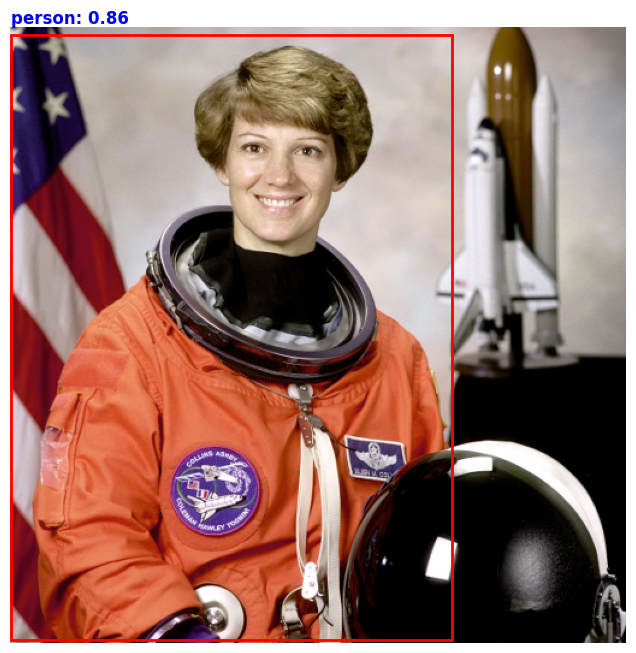

Detalles de las detecciones:
cls_name: person
Clase: person, Confianza: 0.86, Coordenadas: (1, 6, 367, 509)

Procesando imagen 2...


0: 448x640 1 cup, 1 fork, 1 spoon, 1 dining table, 100.4ms
Speed: 2.0ms preprocess, 100.4ms inference, 4.5ms postprocess per image at shape (1, 3, 448, 640)


C:\Users\juano\AppData\Local\Temp\ipykernel_37328\1786140013.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(box.conf.cpu().numpy())


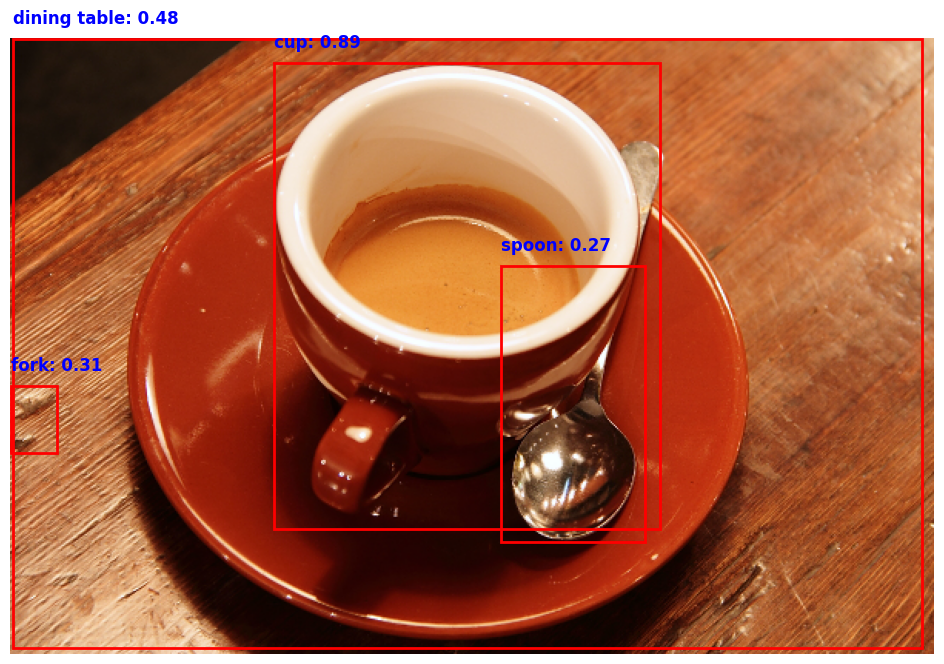

Detalles de las detecciones:
cls_name: cup
Clase: cup, Confianza: 0.89, Coordenadas: (171, 16, 422, 318)
cls_name: dining table
Clase: dining table, Confianza: 0.48, Coordenadas: (1, 0, 592, 396)
cls_name: fork
Clase: fork, Confianza: 0.31, Coordenadas: (0, 225, 30, 269)
cls_name: spoon
Clase: spoon, Confianza: 0.27, Coordenadas: (319, 147, 412, 327)

Procesando imagen 3...


0: 448x640 1 cat, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


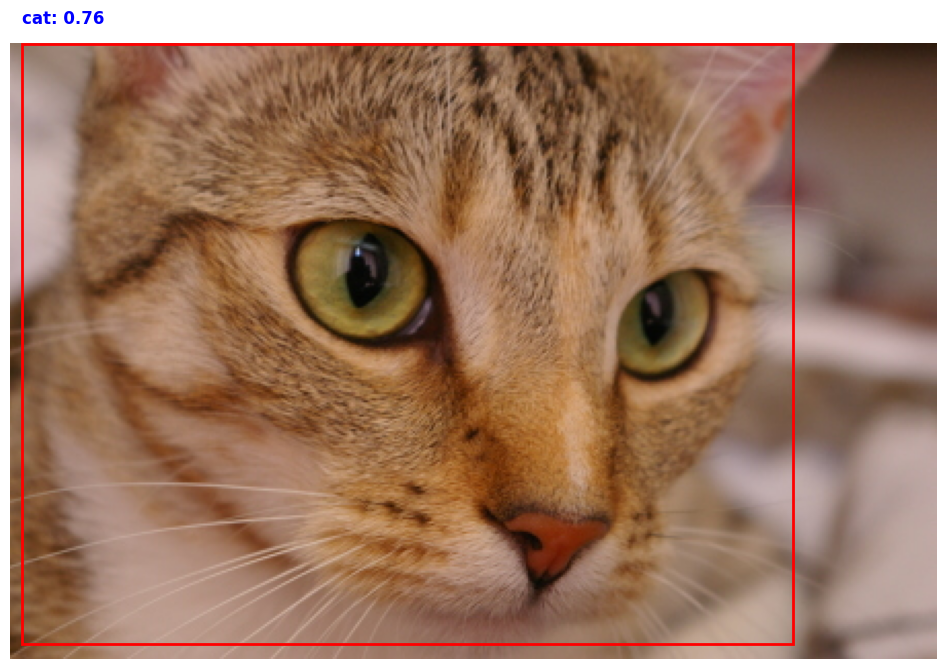

Detalles de las detecciones:
cls_name: cat
Clase: cat, Confianza: 0.76, Coordenadas: (6, 0, 381, 292)


In [5]:
for idx, image in enumerate(images):
    print(f"\nProcesando imagen {idx + 1}...\n")
    # Convertir la imagen a un tensor y moverla al device
    image_tensor = torch.from_numpy(image).to(device)

    # Realizar la detección
    results = model.predict(image, device=device)

    # Mostrar la imagen con las bounding boxes
    show_image_with_boxes(image, results)

    # Obtener información detallada y mostrarla
    print("Detalles de las detecciones:")
    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls)
            cls_name = model.names[cls_id]
            print('cls_name:', cls_name)
            confidence = float(box.conf.cpu().numpy())
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            print(f"Clase: {cls_name}, Confianza: {float(confidence):.2f}, Coordenadas: ({x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f})")


## Uso de una Imagen Externa

Podemos utilizar una imagen externa para probar el modelo.

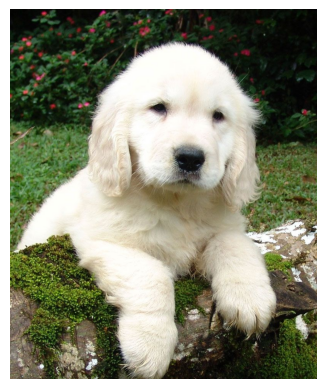


0: 640x544 1 bear, 74.7ms
Speed: 3.0ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


C:\Users\juano\AppData\Local\Temp\ipykernel_37328\2530058511.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(x1, y1 - 10, f"{cls_name}: {float(confidence):.2f}", color='blue', fontsize=12, weight='bold')


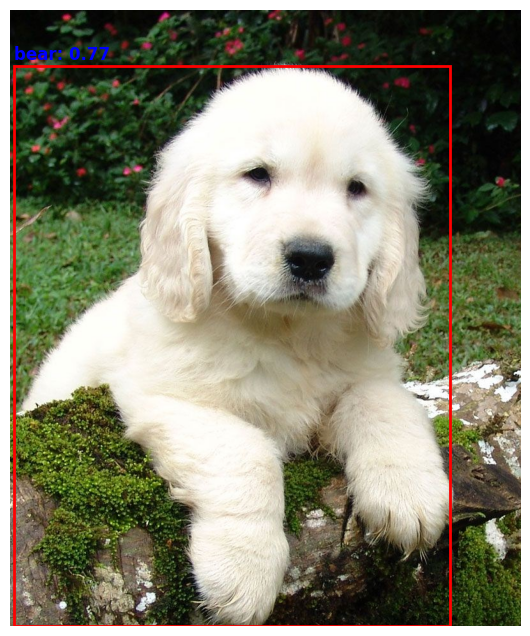

Detalles de las detecciones:
Clase: bear, Confianza: 0.77, Coordenadas: (5, 88, 689, 964)


C:\Users\juano\AppData\Local\Temp\ipykernel_37328\4276844915.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Clase: {cls_name}, Confianza: {float(confidence):.2f}, Coordenadas: ({x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f})")


In [6]:
# URL de una imagen externa
image_url = 'https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg'
external_image = io.imread(image_url)

# Mostrar la imagen original
plt.imshow(external_image)
plt.axis('off')
plt.show()

# Realizar la detección
results = model.predict(external_image, device=device)

# Mostrar la imagen con las bounding boxes
show_image_with_boxes(external_image, results)

# Mostrar detalles de las detecciones
print("Detalles de las detecciones:")
for result in results:
    for box in result.boxes:
        cls_id = int(box.cls)
        cls_name = model.names[cls_id]
        confidence = box.conf.cpu().numpy()
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        print(f"Clase: {cls_name}, Confianza: {float(confidence):.2f}, Coordenadas: ({x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f})")
